# Introduction

In this project, the similarity between Manhattan (New York) and Downtown Toronto (Toronto) will be compared. Say that there will be a upcoming holiday and you have two options for visit:  New York and Toronto. Which one would you like to go? Let's compare them from the counts of Coffee Shop, Hotel, Café, Restaurant, Gastropub.

## Data Preparation

First of all, we need get geo data of two cities from website.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Preapre geo data for New York

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_ny_data = newyork_data['features']

In [5]:
neighborhoods_ny_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_ny = pd.DataFrame(columns=column_names)

In [7]:
for data in neighborhoods_ny_data:
    borough = data['properties']['borough'] 
    neighborhood_ny_name = data['properties']['name']
        
    neighborhood_ny_latlon = data['geometry']['coordinates']
    neighborhood_ny_lat = neighborhood_ny_latlon[1]
    neighborhood_ny_lon = neighborhood_ny_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_ny_name,
                                          'Latitude': neighborhood_ny_lat,
                                          'Longitude': neighborhood_ny_lon}, ignore_index=True)

In [8]:
neighborhoods_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
manhattan_data = neighborhoods_ny[neighborhoods_ny['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


### Prepare geo data for Toronto

In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

response = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(response.text, features="html.parser")

table_data = soup.select('table.wikitable.sortable > tbody > tr')
theads = table_data[0].select('th')
trows = table_data[1:]

columns = []
for thead in theads:
    columns.append(thead.get_text().strip())

data_rows = [[] for col in columns]
for row in trows:
    tds = row.select('td')
    for idx, td in enumerate(tds):
        data_rows[idx].append(td.get_text().strip())

trt = pd.DataFrame()
for idx, col in enumerate(columns):
    trt[col] = data_rows[idx]

trt.to_csv(r'toronto_neighbor.csv', index=False)

In [11]:
trt.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [12]:
def get_pos(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    if location is None:
        return [0,0]
    latitude = location.latitude
    longitude = location.longitude
    print(address, latitude, longitude)
    return [latitude, longitude]

In [13]:
trt['Neighbourhood_Toronto'] = trt['Neighbourhood'] + ', Toronto'
new_cols = trt['Neighbourhood_Toronto'].apply(lambda nbh: get_pos(nbh))

trt['Latitude'] = new_cols.apply(lambda x: x[0])
trt['Longitude'] = new_cols.apply(lambda x: x[1])
trt = trt[trt['Latitude'] != 0.0]
trt = trt[trt['Longitude'] != 0.0]
trt.reset_index(drop=True, inplace=True)
trt.head()

Parkwoods, Toronto 43.7611243 -79.3240594
Victoria Village, Toronto 43.732658 -79.3111892
Harbourfront, Toronto 43.6400801 -79.3801495
Regent Park, Toronto 43.6607056 -79.3604569
Lawrence Heights, Toronto 43.7227784 -79.4509332
Lawrence Manor, Toronto 43.7220788 -79.4375067
Islington Avenue, Toronto 43.7192407 -79.5570574
Rouge, Toronto 43.8049304 -79.1658374
Malvern, Toronto 43.8091955 -79.2217008
Don Mills North, Toronto 43.737178 -79.3434514
Woodbine Gardens, Toronto 43.7120785 -79.3025673
Parkview Hill, Toronto 43.7062977 -79.3219073
Ryerson, Toronto 43.65815275 -79.37908010263
Garden District, Toronto 43.6565019 -79.3771275
Glencairn, Toronto 43.7087117 -79.4406853
Cloverdale, Toronto 43.633637 -79.5497447
Islington, Toronto 43.6453376 -79.52487
Martin Grove, Toronto 43.653963 -79.387207
Princess Gardens, Toronto 43.6404664 -79.3912237
West Deane Park, Toronto 43.6631995 -79.5685684
Highland Creek, Toronto 43.7901172 -79.1733344
Rouge Hill, Toronto 43.7802711 -79.1304992
Port Unio

,Postcode,Borough,Neighbourhood,Neighbourhood_Toronto,Latitude,Longitude
0,M3A,North York,Parkwoods,"Parkwoods, Toronto",43.761124,-79.324059
1,M4A,North York,Victoria Village,"Victoria Village, Toronto",43.732658,-79.311189
2,M5A,Downtown Toronto,Harbourfront,"Harbourfront, Toronto",43.640080,-79.380150
3,M5A,Downtown Toronto,Regent Park,"Regent Park, Toronto",43.660706,-79.360457
4,M6A,North York,Lawrence Heights,"Lawrence Heights, Toronto",43.722778,-79.450933


In [19]:
trtdowntown_data = trt[trt['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
trtdowntown_data.head()

,Postcode,Borough,Neighbourhood,Neighbourhood_Toronto,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,"Harbourfront, Toronto",43.640080,-79.380150
1,M5A,Downtown Toronto,Regent Park,"Regent Park, Toronto",43.660706,-79.360457
2,M5B,Downtown Toronto,Ryerson,"Ryerson, Toronto",43.658153,-79.379080
3,M5B,Downtown Toronto,Garden District,"Garden District, Toronto",43.656502,-79.377128
4,M5C,Downtown Toronto,St. James Town,"St. James Town, Toronto",43.669403,-79.372704


In [20]:
trtdowntown_data.drop(['Postcode', 'Neighbourhood_Toronto'], axis=1, inplace=True)

In [21]:
trtdowntown_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Downtown Toronto,Harbourfront,43.640080,-79.380150
1,Downtown Toronto,Regent Park,43.660706,-79.360457
2,Downtown Toronto,Ryerson,43.658153,-79.379080
3,Downtown Toronto,Garden District,43.656502,-79.377128
4,Downtown Toronto,St. James Town,43.669403,-79.372704


## Exploratory Data Analysis

### Grpahic Map of two areas

In [ ]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods_ny['Latitude'],
                                           neighborhoods_ny['Longitude'],
                                           neighborhoods_ny['Borough'],
                                           neighborhoods_ny['Neighborhood']):
    label = '{}, {}'.format(neighborhoods_ny, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [ ]:
# create map of Manhattan using latitude and longitude values
map_trtdowntown = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(trtdowntown_data['Latitude'],
                           trtdowntown_data['Longitude'],
                           trtdowntown_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_trtdowntown)  
    
map_trtdowntown

In [14]:
CLIENT_ID = '2OGJEGMXUMQB4OESKUJ22DTXAZAYAGPYT1OR310CXAULRYDE' # your Foursquare ID
CLIENT_SECRET = 'ZD3ZKJOB2P2DRCSEONN31KSMT4OBCFMTIPQNOF3T3FJIQJBA' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2OGJEGMXUMQB4OESKUJ22DTXAZAYAGPYT1OR310CXAULRYDE
CLIENT_SECRET:ZD3ZKJOB2P2DRCSEONN31KSMT4OBCFMTIPQNOF3T3FJIQJBA


### Leverage Foursquare for details

In [22]:
def getNearbyVenuesTrt(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
def getNearbyVenuesNy(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
trt_venues = getNearbyVenuesTrt(names=trtdowntown_data['Neighbourhood'],
                            latitudes=trtdowntown_data['Latitude'],
                            longitudes=trtdowntown_data['Longitude'])

Harbourfront
Regent Park
Ryerson
Garden District
St. James Town
Berczy Park
Central Bay Street
Christie
Adelaide
King
Richmond
Harbourfront East
Toronto Islands
Union Station
Design Exchange
Toronto Dominion Centre
Commerce Court
Victoria Hotel
Harbord
University of Toronto
Chinatown
Grange Park
Kensington Market
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South Niagara
Rosedale
Cabbagetown
St. James Town
First Canadian Place
Underground city
Church and Wellesley


In [25]:
# type your answer here

manhattan_venues = getNearbyVenuesNy(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [26]:
trt_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.64008,-79.38015,Harbour Square Park,43.639253,-79.378395,Park
1,Harbourfront,43.64008,-79.38015,Lake Ontario,43.638945,-79.379665,Lake
2,Harbourfront,43.64008,-79.38015,Harbourfront,43.639526,-79.380688,Neighborhood
3,Harbourfront,43.64008,-79.38015,BeaverTails,43.639899,-79.380197,Bakery
4,Harbourfront,43.64008,-79.38015,Miku,43.641374,-79.377531,Japanese Restaurant


In [27]:
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [28]:
trt_venues['Venue Category'].value_counts()

Coffee Shop                        235
Café                               131
Restaurant                          83
Hotel                               81
Italian Restaurant                  58
Pizza Place                         53
Bakery                              53
Japanese Restaurant                 50
Bar                                 44
Gym                                 37
American Restaurant                 35
Vegetarian / Vegan Restaurant       33
Steakhouse                          33
Gastropub                           33
Sandwich Place                      31
Park                                29
Sushi Restaurant                    28
Deli / Bodega                       28
Grocery Store                       28
Seafood Restaurant                  26
Burger Joint                        26
Breakfast Spot                      25
Beer Bar                            25
Chinese Restaurant                  25
Thai Restaurant                     24
Fast Food Restaurant     

In [29]:
manhattan_venues['Venue Category'].value_counts()

Italian Restaurant                          125
Coffee Shop                                 122
American Restaurant                          82
Café                                         80
Bakery                                       72
Pizza Place                                  70
Hotel                                        67
Park                                         65
Gym                                          62
Gym / Fitness Center                         58
Mexican Restaurant                           56
Cocktail Bar                                 56
French Restaurant                            53
Spa                                          51
Bar                                          50
Sushi Restaurant                             49
Chinese Restaurant                           47
Japanese Restaurant                          45
Sandwich Place                               45
Wine Shop                                    44
Wine Bar                                

In [59]:
ny_top = manhattan_venues['Venue Category'].value_counts()

In [65]:
trt_top = trt_venues['Venue Category'].value_counts()
trt_top['Coffee Shop']

235

In [74]:
combine_list = ny_top.keys()[:10]

for item in trt_top.keys()[:10]:
    if item not in combine_list:
        combine_list = np.append(combine_list, item)
combine_list

array(['Italian Restaurant', 'Coffee Shop', 'American Restaurant', 'Café',
       'Bakery', 'Pizza Place', 'Hotel', 'Park', 'Gym',
       'Gym / Fitness Center', 'Restaurant', 'Japanese Restaurant', 'Bar'],
      dtype=object)

In [75]:
venues_df = pd.DataFrame(columns=['venue_name', 'trt', 'ny'])
venues_df['venue_name'] = combine_list
trt_list = []
ny_list = []
for item in combine_list:
    if item in trt_top.keys():
        trt_list.append(trt_top[item])
    else:
        trt_list(0)
    if item in ny_top.keys():
        ny_list.append(ny_top[item])
    else:
        ny_list.append(0)
venues_df['trt'] = trt_list
venues_df['ny'] = ny_list
venues_df

,venue_name,trt,ny
0,Italian Restaurant,58,125
1,Coffee Shop,235,122
2,American Restaurant,35,82
3,Café,131,80
4,Bakery,53,72
5,Pizza Place,53,70
6,Hotel,81,67
7,Park,29,65
8,Gym,37,62
9,Gym / Fitness Center,10,58


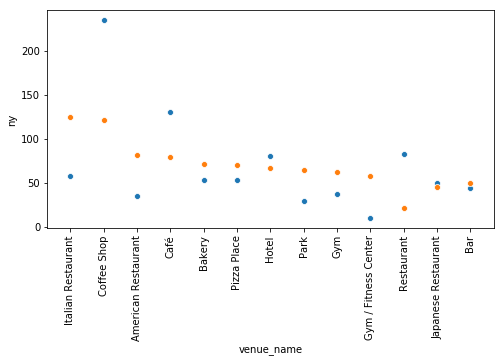

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,4))
plt.setp(ax.get_xticklabels(), rotation=90)
sns.scatterplot(x="venue_name", y="trt", data=venues_df)
sns.scatterplot(x="venue_name", y="ny", data=venues_df)

In [80]:
from scipy.stats import f_oneway
trt_ = venues_df['trt']
ny_ = venues_df['ny']
f_oneway(trt_, ny_)

F_onewayResult(statistic=0.0073466389126974185, pvalue=0.9324059881993899)

pvalue >> 0.05 which indicates that the top 10 venues in Toronto Downtown and Manhattan have no obvious difference. The count of Coffee Shop, Hotel, Café, Restaurant, Gastropub have similarity.